In [54]:
import numpy as np
from matplotlib import pyplot as plt

from os import listdir
from os.path import join
from scipy.io import wavfile

import sys

import librosa
import librosa.display

import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from keras.optimizers import Adam


from sklearn.model_selection import train_test_split


import IPython.display as ipd
from IPython.core.display import display, HTML


In [2]:
def trim_silence(audio, n_noise_samples=1000, noise_factor=1.0, mean_filter_size=100):
    """ Removes the silence at the beginning and end of the passed audio data
    Fits noise based on the last n_noise_samples samples in the period
    Finds where the mean-filtered magnitude > noise
    :param audio: numpy array of audio
    :return: a trimmed numpy array
    """
    start = 0
    end = len(audio)-1

    mag = abs(audio)

    noise_sample_period = mag[end-n_noise_samples:end]
    noise_threshold = noise_sample_period.max()*noise_factor

    mag_mean = np.convolve(mag, [1/float(mean_filter_size)]*mean_filter_size, 'same')

    # find onset
    for idx, point in enumerate(mag_mean):
        if point > noise_threshold:
            start = idx
            break

    # Reverse the array for trimming the end
    for idx, point in enumerate(mag_mean[::-1]):
        if point > noise_threshold:
            end = len(audio) - idx
            break

    return audio[start:end]

In [3]:
def pad_trunc(aud, max_ms):
    sig, sr = aud
    num_rows, sig_len = sig.shape
    max_len = sr//1000 * max_ms

    if (sig_len > max_len):
      # Truncate the signal to the given length
      sig = sig[:,:max_len]

    elif (sig_len < max_len):
      # Length of padding to add at the beginning and end of the signal
      pad_begin_len = random.randint(0, max_len - sig_len)
      pad_end_len = max_len - sig_len - pad_begin_len

      # Pad with 0s
      pad_begin = torch.zeros((num_rows, pad_begin_len))
      pad_end = torch.zeros((num_rows, pad_end_len))

      sig = torch.cat((pad_begin, sig, pad_end), 1)
      
    return (sig, sr)

In [4]:
def get_spectrogram(waveform):
  # Padding for files with less than 16000 samples
  zero_padding = tf.zeros([max_size] - tf.shape(waveform), dtype=tf.float32)

  # Concatenate audio with padding so that all audio clips will be of the 
  # same length
  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)

  spectrogram = tf.abs(spectrogram)

  return spectrogram

In [5]:
def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)


In [6]:
files = 'recordings/'
ds_files = listdir(files)

X = []
y = []

s = []

for file in ds_files:
    label = int(file.split("_")[0])
    rate, data = wavfile.read(join(files, file))
    
    print(data.shape)
    trimmed_data = trim_silence(data.astype(np.float16))
    X.append(trimmed_data)
    y.append(label)
    
    s.append(trimmed_data.shape[0])
    

max_size = np.max(s)

print(max_size)


# pad
X = [ np.pad(x, (0, max_size - x.shape[0])) for x in X ]




(3315,)
(3363,)
(3591,)
(2644,)
(2628,)
(4935,)
(2073,)
(3673,)
(2972,)
(3948,)
(4715,)
(2441,)
(3582,)
(5976,)
(3293,)
(2495,)
(5158,)
(4571,)
(3310,)
(4086,)
(2479,)
(6807,)
(3891,)
(2935,)
(3557,)
(2922,)
(3084,)
(4881,)
(3039,)
(3850,)
(1896,)
(2673,)
(2854,)
(3320,)
(3513,)
(3086,)
(2688,)
(3326,)
(2418,)
(4083,)
(3197,)
(3428,)
(4483,)
(2760,)
(4657,)
(3984,)
(2362,)
(3768,)
(2657,)
(4041,)
(3292,)
(2483,)
(3779,)
(2995,)
(2716,)
(3823,)
(4117,)
(3531,)
(2320,)
(2910,)
(4175,)
(2629,)
(4252,)
(4506,)
(3803,)
(4737,)
(2185,)
(3446,)
(2739,)
(3451,)
(3950,)
(4067,)
(2613,)
(1873,)
(4741,)
(4663,)
(3119,)
(4607,)
(2097,)
(3817,)
(4120,)
(3772,)
(2740,)
(3673,)
(2330,)
(3615,)
(1632,)
(2624,)
(3472,)
(3279,)
(4100,)
(1538,)
(4186,)
(7140,)
(3539,)
(2891,)
(3380,)
(3821,)
(4290,)
(4040,)
(1988,)
(2226,)
(2608,)
(4727,)
(2197,)
(2695,)
(3659,)
(3356,)
(3164,)
(3249,)
(3952,)
(6186,)
(4621,)
(2559,)
(1880,)
(3887,)
(2440,)
(3787,)
(2342,)
(4499,)
(1876,)
(2351,)
(2476,)
(3361,)
(3421,)


(4488,)
(1858,)
(3656,)
(3343,)
(2744,)
(2594,)
(3311,)
(5136,)
(3853,)
(3854,)
(4984,)
(3839,)
(3442,)
(1838,)
(2550,)
(1970,)
(3348,)
(3397,)
(5381,)
(4054,)
(2788,)
(4213,)
(2481,)
(4187,)
(2230,)
(2846,)
(2732,)
(2524,)
(2016,)
(3938,)
(6884,)
(4622,)
(5157,)
(4089,)
(3955,)
(2916,)
(3902,)
(4480,)
(3522,)
(3705,)
(4188,)
(3172,)
(5332,)
(3543,)
(3353,)
(3559,)
(3578,)
(4294,)
(5470,)
(2548,)
(3065,)
(3598,)
(1968,)
(2570,)
(2561,)
(3235,)
(3429,)
(1805,)
(3062,)
(3608,)
(3857,)
(2456,)
(3159,)
(2368,)
(3507,)
(4076,)
(2493,)
(2226,)
(3199,)
(3150,)
(3410,)
(3421,)
(2663,)
(3668,)
(3204,)
(1722,)
(5426,)
(1976,)
(2397,)
(3700,)
(2612,)
(4070,)
(3348,)
(4346,)
(2706,)
(3224,)
(4495,)
(3870,)
(3752,)
(2985,)
(3241,)
(2669,)
(5517,)
(2940,)
(3764,)
(4005,)
(3357,)
(2080,)
(4205,)
(3964,)
(1801,)
(3483,)
(1434,)
(4796,)
(3022,)
(4087,)
(4296,)
(3618,)
(3962,)
(3119,)
(3398,)
(4187,)
(2998,)
(2885,)
(4431,)
(6112,)
(2384,)
(3522,)
(2671,)
(4242,)
(3062,)
(4275,)
(3049,)
(2237,)
(3936,)


(2098,)
(3628,)
(4143,)
(3581,)
(3468,)
(4962,)
(3648,)
(4982,)
(2449,)
(3982,)
(3480,)
(6074,)
(3424,)
(3164,)
(1805,)
(3900,)
(2718,)
(3755,)
(3399,)
(4434,)
(2403,)
(3849,)
(3982,)
(4604,)
(3273,)
(3653,)
(3928,)
(3608,)
(1843,)
(3604,)
(5475,)
(4783,)
(1593,)
(1682,)
(5002,)
(3186,)
(2703,)
(3997,)
(3802,)
(2774,)
(2427,)
(2711,)
(3411,)
(3332,)
(3659,)
(3414,)
(3233,)
(3123,)
(4746,)
(3303,)
(3990,)
(1778,)
(3608,)
(5165,)
(5914,)
(4465,)
(2979,)
(3459,)
(3626,)
(4934,)
(1525,)
(3404,)
(3896,)
(3355,)
(3992,)
(2579,)
(3585,)
(4349,)
(4229,)
(4895,)
(5482,)
(4484,)
(2739,)
(2478,)
(5159,)
(4014,)
(2366,)
(2170,)
(5052,)
(2784,)
(2697,)
(3780,)
(3841,)
(1913,)
(4087,)
(3383,)
(2639,)
(2952,)
(3402,)
(1953,)
(3149,)
(2766,)
(2532,)
(4782,)
(3412,)
(2648,)
(3992,)
(5090,)
(4808,)
(2301,)
(4341,)
(3187,)
(3708,)
(3306,)
(3104,)
(2437,)
(1933,)
(2353,)
(3678,)
(3264,)
(5616,)
(3290,)
(2770,)
(3009,)
(4300,)
(2333,)
(3005,)
(2768,)
(2629,)
(4002,)
(4267,)
(4135,)
(3400,)
(4605,)
(4209,)


In [7]:
train_ratio = 0.60
validation_ratio = 0.20
test_ratio = 0.20

# train is now 60% of the entire data set
# the _junk suffix means that we drop that variable completely
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio)

# test is now 20% of the initial data set
# validation is now 20% of the initial data set
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 

print(len(x_train), len(x_val), len(x_test))

1800 600 600


[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

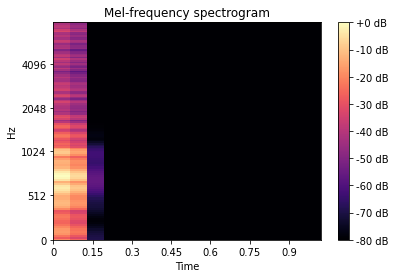

In [8]:
#librosa.feature.mfcc(y_cut, n_fft=n_fft, hop_length=512,n_mfcc=128)

#spec = librosa.stft(X[1500])
sr = 8000
S = librosa.feature.melspectrogram(X[1500], sr)

fig, ax = plt.subplots()
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')





/home/leand/anaconda3/envs/my-conda-env/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
/home/leand/anaconda3/envs/my-conda-env/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  if __name__ == '__main__':


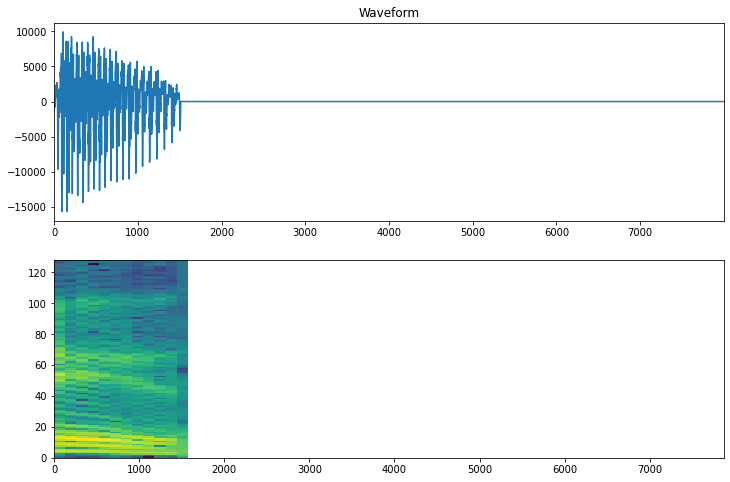

In [9]:
waveform = X[0]
spectrogram = get_spectrogram(waveform)


timescale = np.arange(waveform.shape[0])
fig, axes = plt.subplots(2, figsize=(12, 8))
axes[0].plot(timescale, waveform)
axes[0].set_title('Waveform')
axes[0].set_xlim([0, max_size])
plot_spectrogram(spectrogram.numpy(), axes[1])


In [10]:

x_train_spec = []
for x in x_train:
    x_train_spec.append(get_spectrogram(x))
    
x_train_spec = np.array(x_train_spec)


x_val_spec = []
for x in x_val:
    x_val_spec.append(get_spectrogram(x))

x_val_spec = np.array(x_val_spec)

In [11]:

x_train_mel = []
for x in x_train:
    spec = librosa.feature.melspectrogram(y=x, sr=8000)
    x_train_mel.append(librosa.power_to_db(spec, ref=np.max))
    
x_train_mel = np.array(x_train_mel)


x_val_mel = []
for x in x_val:
    spec = librosa.feature.melspectrogram(y=x, sr=8000)
    x_val_mel.append(librosa.power_to_db(spec, ref=np.max))
    
x_val_mel = np.array(x_val_mel)


In [12]:
x_train_mfcc = []
for x in x_train:
    spec = librosa.feature.mfcc(y=x, sr=8000)
    x_train_mfcc.append(spec)
    
x_train_mfcc = np.array(x_train_mfcc)


x_val_mfcc = []
for x in x_val:
    spec = librosa.feature.mfcc(y=x, sr=8000)
    x_val_mfcc.append(spec)
    
x_val_mfcc = np.array(x_val_mfcc)

In [13]:
#for spectrogram, _ in spectrogram_ds.take(1):
#  input_shape = spectrogram.shape
#print('Input shape:', input_shape)

x_train_cur = x_train_mfcc
x_val_cur = x_val_mfcc
input_shape = x_train_cur.shape
num_labels = 10

print(input_shape)

#norm_layer = preprocessing.Normalization()
#norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

model = models.Sequential([
    layers.Input(shape=(*x_train_cur[0].shape, 1)),
    preprocessing.Resizing(32, 32), 
    #norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.Dropout(0.7),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_labels),
])

model.summary()

(1800, 20, 16)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
dropout (Dropout)            (None, 13, 13, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 10816)             0         
_________________________________________________________________
dense (Dense)                (None, 128) 

In [14]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [15]:
EPOCHS = 25
history = model.fit(
    x_train_cur, 
    np.array(y_train),
    validation_data=(x_val_cur, np.array(y_val)),  
    epochs=EPOCHS
)# 75ms/st

Epoch 1/25
57/57 [==============================] - 2s 28ms/step - loss: 3.0412 - accuracy: 0.4728 - val_loss: 0.7481 - val_accuracy: 0.7517
Epoch 2/25
57/57 [==============================] - 2s 28ms/step - loss: 0.6330 - accuracy: 0.7772 - val_loss: 0.4035 - val_accuracy: 0.8633
Epoch 3/25
57/57 [==============================] - 2s 29ms/step - loss: 0.4736 - accuracy: 0.8367 - val_loss: 0.3314 - val_accuracy: 0.8983
Epoch 4/25
57/57 [==============================] - 2s 30ms/step - loss: 0.3920 - accuracy: 0.8744 - val_loss: 0.3288 - val_accuracy: 0.8983
Epoch 5/25
57/57 [==============================] - 2s 30ms/step - loss: 0.2931 - accuracy: 0.8939 - val_loss: 0.2872 - val_accuracy: 0.9150
Epoch 6/25
57/57 [==============================] - 2s 30ms/step - loss: 0.2616 - accuracy: 0.9106 - val_loss: 0.3087 - val_accuracy: 0.9017
Epoch 7/25
57/57 [==============================] - 2s 29ms/step - loss: 0.2431 - accuracy: 0.9150 - val_loss: 0.3642 - val_accuracy: 0.8967
Epoch 8/25
57

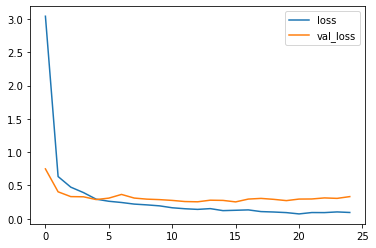

In [16]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [19]:
import pyaudio
import wave

chunk = 1024  # Record in chunks of 1024 samples
sample_format = pyaudio.paInt16  # 16 bits per sample
channels = 1
fs = 8000  # Record at 44100 samples per second
seconds = 2
filename = "output.wav"

p = pyaudio.PyAudio()  # Create an interface to PortAudio

print('Recording')

stream = p.open(format=sample_format,
                channels=channels,
                rate=fs,
                frames_per_buffer=chunk,
                input=True)

frames = []  # Initialize array to store frames

# Store data in chunks for 3 seconds
for i in range(0, int(fs / chunk * seconds)):
    data = stream.read(chunk)
    frames.append(data)

# Stop and close the stream 
stream.stop_stream()
stream.close()
# Terminate the PortAudio interface
p.terminate()

print('Finished recording')

# Save the recorded data as a WAV file
wf = wave.open(filename, 'wb')
wf.setnchannels(channels)
wf.setsampwidth(p.get_sample_size(sample_format))
wf.setframerate(fs)
wf.writeframes(b''.join(frames))
wf.close()

Recording
Finished recording


(15360,)
(1319,)
7998 1319
(20, 16)


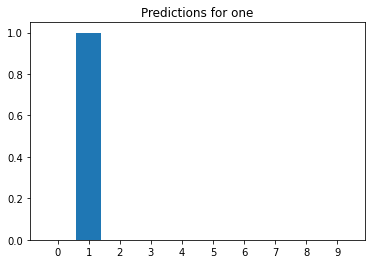

In [26]:
labels = [str(i) for i in range(10)]
rate, data = wavfile.read("output.wav")
print(data.shape)

trimmed_data = trim_silence(data.astype(np.float16))



print(trimmed_data.shape)

print(max_size, trimmed_data.shape[0])

my_X = np.pad(trimmed_data, (0, max_size - trimmed_data.shape[0]))

my_spec = librosa.feature.mfcc(y=my_X, sr=8000)
print(my_spec.shape)

'''
y_pred = model.predict(my_spec.reshape(1, *my_spec.shape, 1))
predicted_categories = tf.argmax(y_pred, axis=1)
print(predicted_categories)
'''

prediction = model(my_spec.reshape(1,*my_spec.shape, 1))
plt.bar(labels, tf.nn.softmax(prediction[0]))
plt.title(f'Predictions for one')
plt.show()


In [ ]:
i = ipd.Audio(trimmed_data, rate=8000)
i

In [48]:
def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))

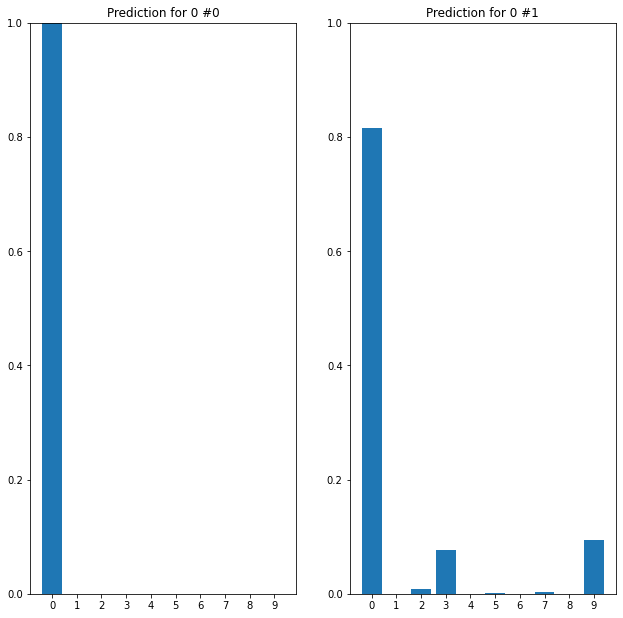

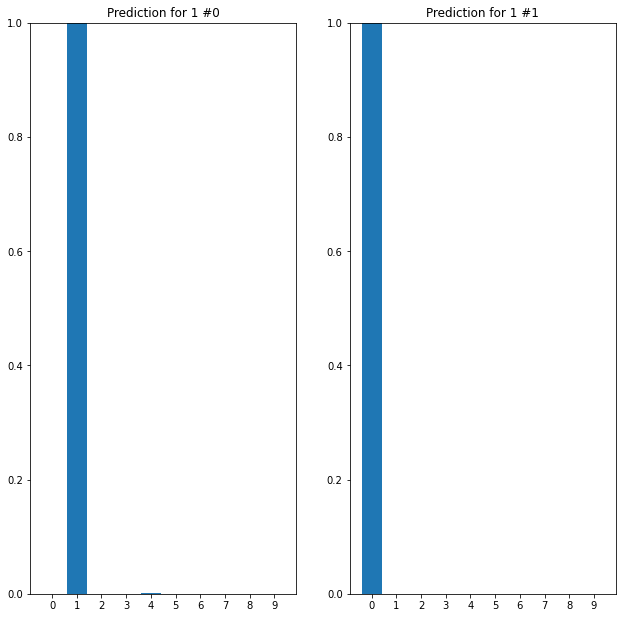

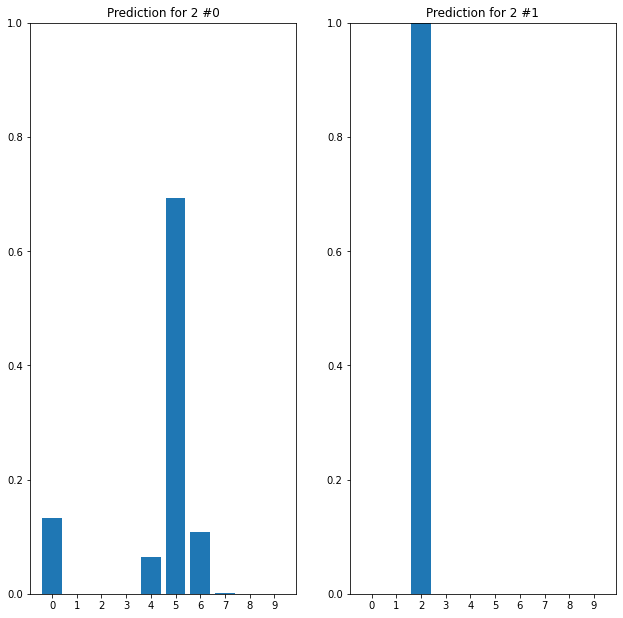

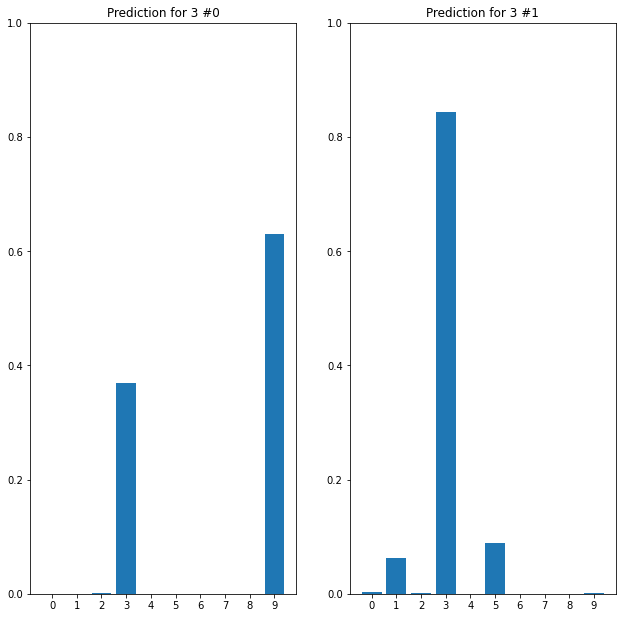

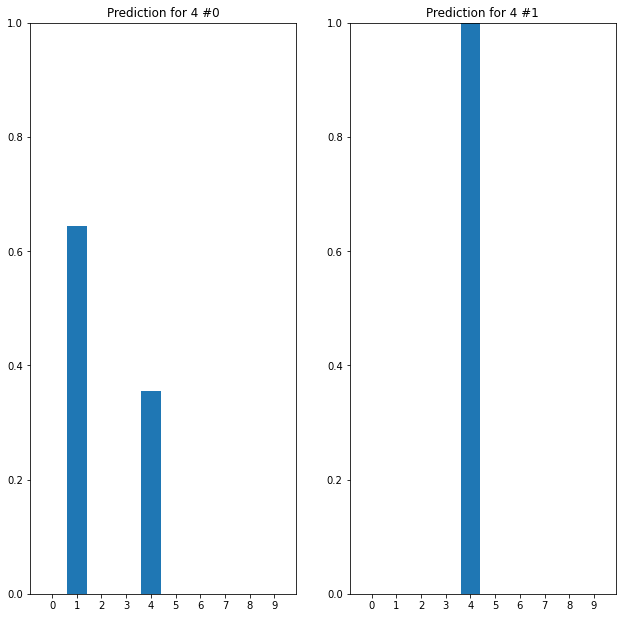

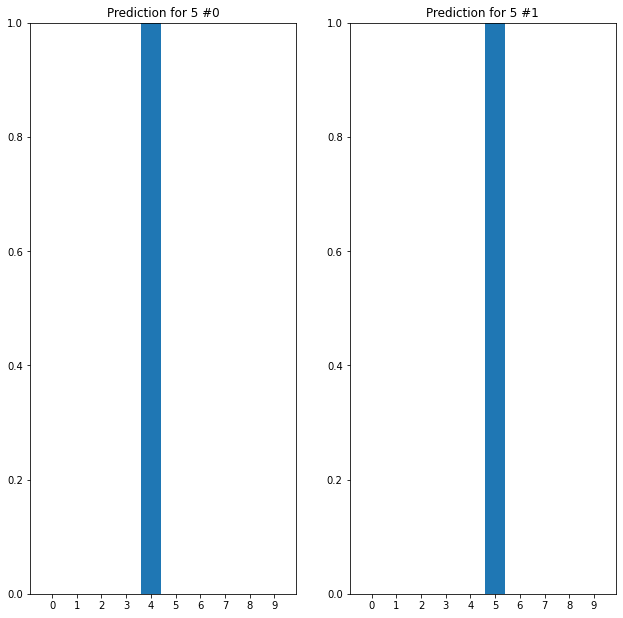

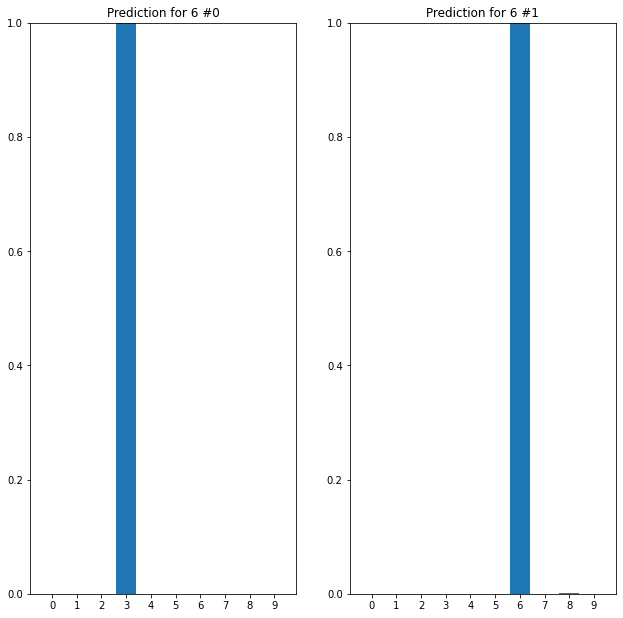

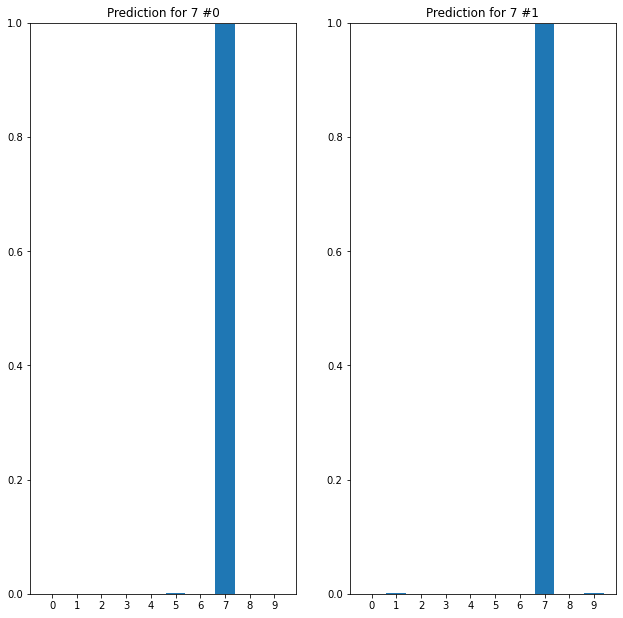

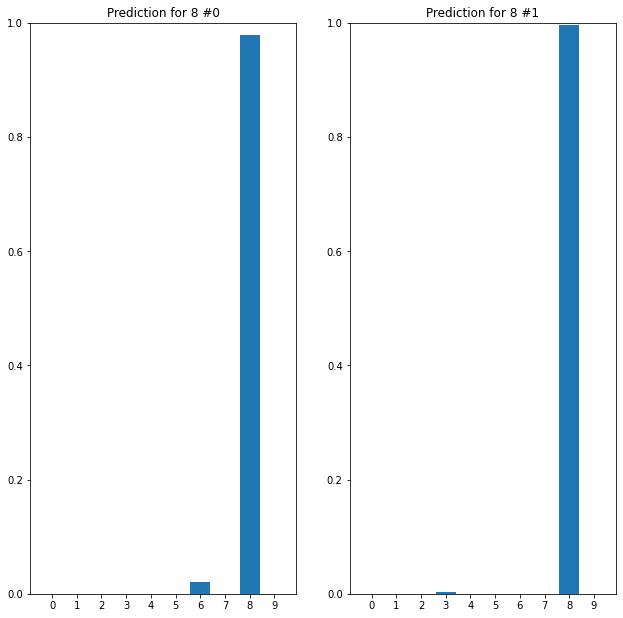

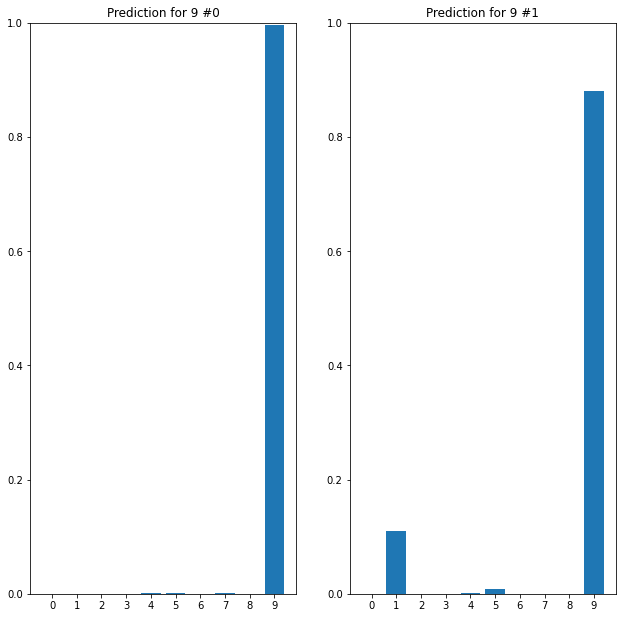

In [73]:
labels = [str(i) for i in range(10)]

ds_files = listdir('new_recordings/')
ds_files.sort()
samples_per_label = 2
ds_chunks = [ds_files[x:x+samples_per_label] for x in range(0, len(ds_files), samples_per_label)]



for chunk in ds_chunks:
    
    fig, axes = plt.subplots(nrows=1, ncols=samples_per_label, squeeze=False)
    
    for file in chunk:
        label = int(file.split("_")[0])
        sample = int(file.split("_")[2].split('.')[0])
        
        ax = axes[0][sample]
        ax.set_ylim([0,1])

        rate, data = wavfile.read(join(files, file))

        trimmed_data = trim_silence(data.astype(np.float16))

        display(ipd.Audio(trimmed_data, rate=8000))

        x = np.pad(trimmed_data, (0, max_size - trimmed_data.shape[0]))

        x_spec = librosa.feature.mfcc(y=x, sr=8000)

        
        (prediction,) = model(x_spec.reshape(1, *x_spec.shape, 1))
        ax.bar(labels, tf.nn.softmax(prediction))
        ax.set_title(f'Prediction for {label} #{sample}')
        
    fig.set_size_inches(10.5, 10.5, forward=True)
    plt.show()

